# Spoken Wiki attentional word recognition pilot task results

In [40]:
import pickle
import numpy as np 
import re 
from pathlib import Path
import pandas as pd
import json
import pickle
import src.util_process_prolific as up 

%matplotlib inline 

import matplotlib.pyplot as plt 
import seaborn as sns
# from matplotlib.ticker import FormatStrFormatter

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
outdir = Path("rebuttal_figs")
outdir.mkdir(parents=True, exist_ok=True)

In [3]:
path_to_human_data = Path('/mindhive/mcdermott/www/imgriff/msjspsych/')
# full paths to .json files 
human_fnames = list(path_to_human_data.glob("cocktail_party_cue_duration/data/*.json"))


len(human_fnames)

180

In [4]:
## Get all subject data into one df for analysis

dfs = []
for fname in human_fnames:
    try:
        dfs.append(up.get_part_df_swc(fname))
    except Exception as e:
        print(e)
        print(fname)
    
# results_df = pd.concat([get_part_df(fname) for fname in human_fnames], axis=0, ignore_index=True)
results_df = pd.concat(dfs)

## Filter for those who passed headphone check 
results_df = results_df[results_df.hc_passed == True]
print(f"Total number of subjects after headphone check: {len(results_df.id_subject.unique())}")
## Filter self reported hearing loss 
results_df = results_df[results_df.hearing_loss == False]
print(f"Total number of subjects after hearing loss check: {len(results_df.id_subject.unique())}")

## Add snr and condition names as columns - unpack from file code in file names 

import re
# get cond name map
map_path = Path('/om2/user/imgriff/projects/torch_2_aud_attn/human_pilot_cue_duration_cond_map.pkl')
with open(map_path, 'rb') as handle:
    stim_cond_map = pickle.load(handle)

stim_cond_map = {f"condition_{k}": v for k,v in stim_cond_map.items()}

## Map wav str to stim_type using condition dict
def get_stim_snr_and_cond(stim_str, stim_cond_map=stim_cond_map):
    condition, cue_dur = None,  None 
    if isinstance(stim_str, str) and not stim_str.startswith('<'):
        cond_str = re.search("condition_(-?\d+)", stim_str)
        if cond_str:
            cond_str = cond_str.group(0)
            cue_dur = stim_cond_map[cond_str]
            condition = 'trial'
        elif 'catch' in stim_str:
            condition = 'catch_trial'
            cue_dur = 2
    return cue_dur, condition

# add as columns 
results_df['cue_dur'], results_df['condition'] = zip(*results_df['stimulus'].apply(get_stim_snr_and_cond))

# cut down df to only have trial answers (remove other meta data)
expmnt_trial_str = "dictionary-text"
trial_results = results_df[results_df.trial_type == expmnt_trial_str]


trial_results = trial_results[trial_results.id_version == 0]
screen_for_full_exp_run = True
# screen based on completion 
total_trials = 42
if screen_for_full_exp_run:
    full_run_subjects = [subj_id for subj_id, did_all_trials in (trial_results.groupby('id_subject').condition.count() == total_trials).items() if did_all_trials == True]
    trial_results = trial_results[trial_results.id_subject.isin(full_run_subjects)]

# Add accuracy 
trial_results['accuracy'] = (trial_results['response_str'] == trial_results['correct_response']).astype('int')
trial_results.groupby('id_subject').trial_index.count()

Expecting property name enclosed in double quotes: line 1 column 71674 (char 71673)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_cue_duration/data/subj_67ceb35b4792192fccbb19c9.json
Expecting ',' delimiter: line 1 column 59751 (char 59750)
/mindhive/mcdermott/www/imgriff/msjspsych/cocktail_party_cue_duration/data/subj_55cca8f81676ab000ff06ef1.json
Total number of subjects after headphone check: 117
Total number of subjects after hearing loss check: 116


id_subject
582c71a66ef28c00019a1068    42
59baf1a2178f1b0001828a26    42
5a7226d9f660ae0001a9a547    42
5a9fa90f873cda00010d29d8    42
5adb9688e0feeb0001ca9622    42
                            ..
67df2438f087a74ea30f779b    42
67e1ea05ef54663f593482b2    42
67e32b89bc01f7bf15d359db    42
67e494e108181d6621738771    42
67e85a8becc5f7048616c4be    42
Name: trial_index, Length: 96, dtype: int64

### Select participants based on catch trial performance

In [5]:
catch_trial_participant_performance = trial_results[trial_results.condition == 'catch_trial'].groupby('id_subject').accuracy.mean()
# catch_trial_particiapnt_performance
print(f"N total participants {len(catch_trial_participant_performance)}")

good_participants = catch_trial_participant_performance[catch_trial_participant_performance >= 10/12].index
print("N good participants ", len(good_participants))

good_results = trial_results[trial_results.id_subject.isin(good_participants)]

analysis_df = good_results[(~good_results.condition.isnull()) & (~good_results.response_str.isna())]
# analysis_df.groupby('id_subject').condition.count()

N total participants 96
N good participants  84


### Print demographics 

In [6]:
### Get quick demographics 
demog_fields = analysis_df[analysis_df.id_subject.isin(good_participants)]
demogs = demog_fields.groupby('id_subject').first()
print("Gender data")
print(demogs.gender.value_counts())
print("Age data")
demogs['age'] = [int(age) if age != '' else np.nan for age in demogs.age ]
print(f"Min: {demogs.age.min()} Max: {demogs.age.max()} Median: {demogs.age.median()}")
print(f"N = {demog_fields.id_subject.nunique()}")

Gender data
gender
Female    43
Male      38
Other      3
Name: count, dtype: int64
Age data
Min: 20.0 Max: 40.0 Median: 32.0
N = 84


In [7]:


### Look at 1 talker sex conditions

manifest = pd.read_pickle("/om/user/imgriff/datasets/human_cue_duration_SWC_2024/manifest_w_transcripts.pdpkl")
manifest["base_trial"] = manifest.mixture_fn.apply(lambda x: x.as_posix().split('/')[-1]) 

## Will add columns 'base_str', 'target_gender', 'target_f0', 'distractor_f0', 'distractor_gender' from manifest to trial_results where trial_results.stimulus == manifest.base_str
analysis_df['base_trial'] = analysis_df.stimulus.apply(lambda x: x.split('/')[-1])

analysis_df = pd.merge(analysis_df,
                        manifest[['base_trial', 'target_gender', 'target_f0', 'distractor_f0', 'distractor_gender', 'distractor_word', 'target_transcripts', 'distractor_transcripts']],
                                    left_on='base_trial', right_on='base_trial', how='left')
analysis_df['confusions'] = (analysis_df.response == analysis_df.distractor_word).astype('int')


# add adjusted accuracy and confusions 
target_words = analysis_df.response.values
target_transcripts = analysis_df.target_transcripts.values
distractor_transcripts = analysis_df.distractor_transcripts.values


adjusted_acc = np.array([int(target_word in target_transcript)
                            if not isinstance(target_transcript, float) else np.nan
                             for target_word, target_transcript in zip(target_words, target_transcripts)
                              ])

adjusted_confs = np.array([int(target_word in distractor_transcript)
                            if not isinstance(distractor_transcript, float) else np.nan
                             for target_word, distractor_transcript in zip(target_words, distractor_transcripts)
                              ])

analysis_df['adjusted_accuracy'] = adjusted_acc
analysis_df['adjusted_confusions'] = adjusted_confs

In [9]:
analysis_df['gender_cond'] = analysis_df['target_gender'].values == analysis_df['distractor_gender'].values
analysis_df['gender_cond'] = analysis_df['gender_cond'].replace({True: 'Same sex', False: 'Different sex'})

In [10]:
analysis_df[analysis_df['condition']=='trial'].groupby(['id_subject', 'cue_dur']).cue_dur.count()

id_subject                cue_dur
582c71a66ef28c00019a1068  0.5        10
                          1.0        10
                          2.0        10
59baf1a2178f1b0001828a26  0.5        10
                          1.0        10
                                     ..
67e494e108181d6621738771  1.0        10
                          2.0        10
67e85a8becc5f7048616c4be  0.5        10
                          1.0        10
                          2.0        10
Name: cue_dur, Length: 252, dtype: int64

### Group participant data for plotting and stats

In [11]:
# get trial data excluding catch trials 


part_summary_df = (analysis_df[analysis_df['condition'] == 'trial'].groupby(['id_subject', "gender_cond", "cue_dur"])
                     .agg({'adjusted_accuracy':['mean', 'sem', 'count'], 'adjusted_confusions':['mean', 'sem', 'count']})
                     .reset_index())

# flatten multiindex 
part_summary_df.columns = ['_'.join(col).strip() for col in part_summary_df.columns.values]
# remove trailing underscore
part_summary_df.columns = [col[:-1] if col.endswith('_') else col for col in part_summary_df.columns.values]


### Get model results

In [12]:
## import class maps
import pickle
cv_word_2_class = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
cv_class_2_word = {v:k for k,v in cv_word_2_class.items()}

### Get conditions 
path_to_expmt_stim = Path("/om/user/imgriff/datasets/human_word_rec_SWC_2024/")
human_exp_word_key = pickle.load( open(path_to_expmt_stim / "human_attn_expmt_word_key.pkl", "rb" )) 
exp_word_2_class = {v:k for k,v in human_exp_word_key.items()}

manifests = pd.read_pickle(path_to_expmt_stim / "human_cue_target_distractor_df_w_meta_transcripts_w_f0.pdpkl")
manifests['word_fname_int'] = manifests['word'].replace(exp_word_2_class)
manifests['stim_name'] = manifests[['gender', 'word_fname_int']].apply(lambda row: f"{row.gender[0]}_{row.word_fname_int:03d}", axis=1)
cols_to_merge = [
                #  'stim_name',
                 'gender',
                 'word',
                 'word_int',
                 'target_f0',
                 'english_distractor_f0',
                 'mandarin_distractor_f0',
                 'dutch_distractor_f0',
                 'target_transcripts',
                 'same_sex_distractor_1_transcripts',
                 'diff_sex_distractor_1_transcripts',
                 "same_sex_dist_1_word",
                 "diff_sex_dist_1_word"

]
manifests['word_int'] = manifests.word.replace(cv_word_2_class)
model_manifest = manifests[cols_to_merge].sort_values(['gender', 'word']).copy()
model_manifest['df_index'] = model_manifest.index



/tmp/ipykernel_3403343/1519741987.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  manifests['word_fname_int'] = manifests['word'].replace(exp_word_2_class)
/tmp/ipykernel_3403343/1519741987.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  manifests['word_int'] = manifests.word.replace(cv_word_2_class)


In [13]:
## import class maps
import pickle
## load WSN vocab mapping 
word_and_speaker_encodings = pickle.load( open( "/om2/user/imgriff/projects/Auditory-Attention/word_and_speaker_encodings_jsinv3.pckl", "rb" )) 
wsn_word_2_class = word_and_speaker_encodings['word_to_idx']
wsn_class_2_word = word_and_speaker_encodings['word_idx_to_word']
cv_word_2_class = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
cv_class_2_word = {v:k for k,v in cv_word_2_class.items()}



In [14]:
from src.util_analysis import model_name_dict
manifest = pd.read_pickle("/om/user/imgriff/datasets/human_cue_duration_SWC_2024/manifest_w_transcripts.pdpkl")


model_names = ['word_task_v10_main_feature_gain_config']


all_model_results = []
all_model_f0_results = []

# Convert condition names to  readable format 
test_condition_dict = {'music':"background_musdb18hq",
                    "babble":"background_cv08talkerbabble",
                    "stationary": "background_issnstationary",
                    "modulated": "background_issnfestenplomp",
                    "audioset": "background_audioset",
                    "natural scene": "background_ieeeaaspcasa",
                    "clean": "SILENCE"}
str_to_cond = {v:k for k,v in test_condition_dict.items()}

# update gt manifests to match readable format 
manifest["background_condition"] = manifest.condition.replace(str_to_cond, )

for model_name in model_names:
    if 'affine' not in model_name and 'no_cue' not in model_name:
        print(model_name)
        output_paths = list(Path(f'/om2/user/rphess/Auditory-Attention/cue_duration_eval/{model_name}').glob('*.csv'))
    else:
        output_paths = list(Path(f'cue_duration_eval/{model_name}').glob('*.csv'))
    if 'v1' in model_name:
        output_paths = list(Path(f'cue_duration_eval_center_crop/{model_name}').glob('*.csv'))


    print(len(output_paths))

    results_dfs = []

    for path in output_paths:
        if "v10" in path.stem and 'talker_' in path.stem:
            continue
        df = pd.read_csv(path)
        # reformat dict
        df['model'] = path.parent.name
        #parts of name 
        parts = path.stem.split(path.parent.name)[-1].split('_')       
        if "background" in path.stem:
            df['background_condition'] = str_to_cond['_'.join(parts[1:3])]
        else:
            df['background_condition'] = parts[1]
        if 'SILENCE' in path.stem:
            df['background_condition'] = 'clean'
            df['snr'] =  'inf' # really np.inf, 6 for plotting 
        else:
            df['snr'] = int(re.search('(-?\d+)dB', path.stem).group(0).strip('dB'))
        df['cue_dur'] = int(re.search('(-?\d+)ms', path.stem).group(0).strip('ms'))
        if "v10" in model_name:
            df['test_index'] = df.index
            df = pd.merge(df,
                model_manifest,
                            left_on=["test_index", "true_word_int"], right_on=["df_index", "word_int"])

        results_dfs.append(df)
    model_results = pd.concat(results_dfs, axis=0, ignore_index=True)
    model_str = model_name_dict[model_name] if model_name in model_name_dict else model_name
    model_results['group'] = model_str
    ## Load in model vocab 
    class_2_word =  wsn_class_2_word if 'WordSpeakerNoise' in model_str else  cv_class_2_word
    model_results['pred_word'] = model_results['pred_word_int'].replace(class_2_word)
    model_results['true_word'] = model_results['true_word_int'].replace(class_2_word)


    # # Add 1-talker condition metadata to model results

    pred_words = model_results.pred_word.values
    target_words = model_results.word.values
    target_transcripts = model_results.target_transcripts.values
    same_sex_distractor_words = model_results.same_sex_dist_1_word.values
    diff_sex_distractor_words = model_results.same_sex_dist_1_word.values
    same_sex_distractor_transcripts = model_results.same_sex_distractor_1_transcripts.values
    diff_sex_distractor_transcripts = model_results.diff_sex_distractor_1_transcripts.values


    adjusted_acc = np.array([int(pred_word in target_transcript or pred_word == target_word)
                                if not isinstance(target_transcript, float) else np.nan
                                for pred_word, target_word, target_transcript in zip(pred_words, target_words, target_transcripts)
                                ])

    adjusted_confs = np.array([int(pred_word in same_sex_transcript or pred_word in diff_sex_transcript or pred_word == same_sex_word or pred_word == diff_sex_word)
                                if not (isinstance(same_sex_transcript, float) and isinstance(diff_sex_transcript, float)) else np.nan
                                for pred_word, same_sex_word, diff_sex_word, same_sex_transcript, diff_sex_transcript in zip(pred_words, same_sex_distractor_words, diff_sex_distractor_words,  same_sex_distractor_transcripts, diff_sex_distractor_transcripts)
                                ])

    
    
    model_results['adjusted_accuracy'] = adjusted_acc
    model_results['adjusted_confusions'] = adjusted_confs
    
    all_model_results.append(model_results)

all_model_results = pd.concat(all_model_results, axis=0, ignore_index=True)

all_model_results['cue_dur'] = all_model_results['cue_dur'] / 1000

word_task_v10_main_feature_gain_config
8


In [15]:
all_model_results['gender_cond'] = all_model_results.background_condition.apply(lambda row: 'Same sex' if 'same' in row else 'Different sex')


In [16]:
all_model_results[all_model_results.cue_dur >= 0.5].cue_dur.value_counts()

cue_dur
1.0    1952
2.0    1952
0.5    1952
Name: count, dtype: int64

### Combine model and participant results

In [17]:
part_summary_df['group'] = f"Participants (N={part_summary_df.id_subject.nunique()})"
part_summary_df.rename(columns={'adjusted_accuracy_mean': 'adjusted_accuracy', 'adjusted_confusions_mean': "adjusted_confusions"}, inplace=True)

all_model_results['group'] = all_model_results['group']
all_results = pd.concat([part_summary_df, all_model_results], axis=0, ignore_index=True)


In [18]:
all_results.groupby(['group',
                     'cue_dur']).adjusted_accuracy.mean()

group                cue_dur
Feature-gain v10     0.25       0.396004
                     0.50       0.471311
                     1.00       0.503586
                     2.00       0.524078
Participants (N=84)  0.50       0.497995
                     1.00       0.508978
                     2.00       0.527186
Name: adjusted_accuracy, dtype: float64

## Make figure for rebuttal 

In [25]:
to_plot.group.unique()

array(['Humans (N=84)', 'Feature-gain v10 '], dtype=object)

/tmp/ipykernel_3403343/1468161806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot.group = to_plot.group.replace({"Participants (N=84)": "Humans (N=84)",


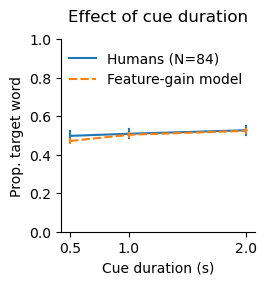

In [ ]:
to_plot = all_results[all_results.cue_dur.isin([0.5,1,2])]
# rename goups 
to_plot.group = to_plot.group.replace({"Participants (N=84)": "Humans (N=84)",
                                       "Feature-gain v10 ": "Feature-gain model"})

#group_order = [ f"Participants (N={part_summary_df.id_subject.nunique()})", 'Model']
# add markers to relplot
fig, ax = plt.subplots(1, figsize=(2.5,2.5))
g = sns.lineplot(data=to_plot, x='cue_dur', y='adjusted_accuracy', # hue='gender_cond',
                # col_wrap=3,
                style='group',# style_order=group_order,
                hue='group',

                # kind='line',
                marker='',
                color='k',
                # height=3, aspect=1,
                err_style='bars', 
                errorbar=('se', 1),)

# set labels 
ax.set_xlabel("Cue duration (s)")
ax.set_ylabel("Prop. target word")
sns.despine()
# add xtick labels 
ax.set_xticks(ticks=to_plot.cue_dur.unique())
ax.set_xticklabels(to_plot.cue_dur.unique())
ax.legend(title='', frameon=False)
plt.ylim(0,1)
plt.title(f"Effect of cue duration", y=1.05)

# plt.savefig(outdir / "cue_duration_effect_human_model.pdf", bbox_inches='tight', transparent=True)